In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier

import warnings
warnings.filterwarnings(action='ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/forest-fires-data-set/forestfires.csv


In [2]:
df = pd.read_csv('../input/forest-fires-data-set/forestfires.csv')
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


## About Data
For more information, read [Cortez and Morais, 2007].

**X** - x-axis spatial coordinate within the Montesinho park map: 1 to 9  
**Y** - y-axis spatial coordinate within the Montesinho park map: 2 to 9  
**month** - month of the year: 'jan' to 'dec'  
**day** - day of the week: 'mon' to 'sun'  
**FFMC** - FFMC index from the FWI system: 18.7 to 96.20  
**DMC** - DMC index from the FWI system: 1.1 to 291.3  
**DC** - DC index from the FWI system: 7.9 to 860.6   
**ISI** - ISI index from the FWI system: 0.0 to 56.10  
**temp** - temperature in Celsius degrees: 2.2 to 33.30  
**RH** - relative humidity in %: 15.0 to 100  
**wind** - wind speed in km/h: 0.40 to 9.40  
**rain** - outside rain in mm/m2 : 0.0 to 6.4  
**area** - the burned area of the forest (in ha): 0.00 to 1090.84  (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


* This is pretty small dataset of shape 517x13
* With no missing data
* For preprocessing all we need to do is try to convert these 2 object columns {month and day}

In [4]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


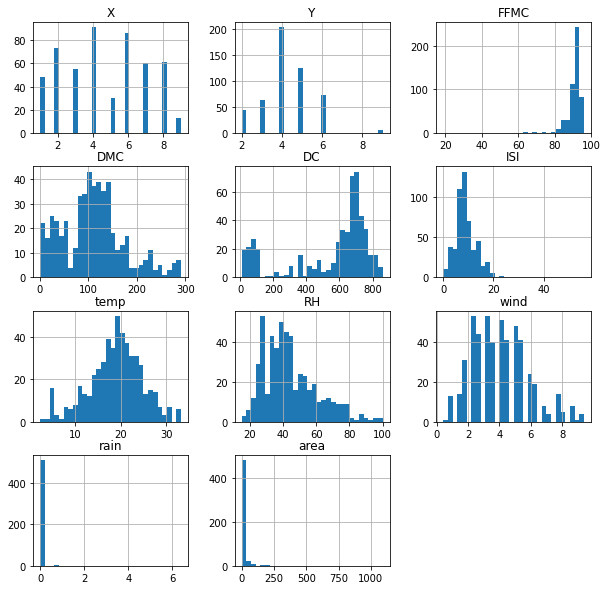

In [5]:
df.hist(figsize=(10,10), bins=30);

In [6]:
'''%%time
sns.pairplot(df);''';

# Preprocessing 

In [7]:
c= df.select_dtypes(include='object')
print('No of unique values in each features')
display(c.nunique())
print()
print(c.month.unique(),'\n')
print(c.day.unique(),'\n')

c.value_counts()

No of unique values in each features


month    12
day       7
dtype: int64


['mar' 'oct' 'aug' 'sep' 'apr' 'jun' 'jul' 'feb' 'jan' 'dec' 'may' 'nov'] 

['fri' 'tue' 'sat' 'sun' 'mon' 'wed' 'thu'] 



month  day
aug    sun    40
sep    fri    38
aug    sat    29
sep    mon    28
aug    tue    28
              ..
feb    wed     1
jan    sat     1
       sun     1
apr    mon     1
       fri     1
Length: 64, dtype: int64

As we know this dataset is for the year 2007
* month contains 12 months name
* day contains 7 day name

However these are **Ordinal  categorical** features
> Ordinal data is a kind of categorical data with a set order or scale to it. ( ex B.Tech, M.Tech , Phd etc)

In [8]:
# Try code with any given value it will return the location of the value in the list
['sun', 'mon','tue','wed', 'thu', 'fri', 'sat' ].index('wed')

### this is the same thing which we are doing in this
### df.day.apply(lambda x: ordering.index(x))

3

In [9]:
def ordinal_encode(df,column, ordering):
    df= df.copy()
    df[column]= df[column].apply(lambda x: ordering.index(x))
    return df

In [10]:
def preprocess_input(df, task):
    df=df.copy()
    # Ordinal encode month and day columns
    df = ordinal_encode(
    df,
    column ='month',
    ordering=['jan','feb', 'mar','apr','may','jun','jul', 'aug', 'sep' , 'oct', 'nov','dec' ])
    df = ordinal_encode(
    df,
    column ='day',
    ordering=['sun', 'mon','tue','wed', 'thu', 'fri', 'sat' ])
    
    # Data creation for regression and classification
    
    if task == 'regression':
        y=df['area']
    elif task== 'classification':
        y=df['area'].apply(lambda x: 1 if x>0 else 0)
    X = df.drop('area', axis=1)
    
    # Train test split
    X_train , X_test , y_train, y_test = train_test_split(X,y,train_size=0.7, shuffle = True, random_state= 7)
    
    ## Storing columns name, so that after scaling we can assign column names to array
    col=X_train.columns
    
    # Scale Feature Data (X)
    scaler= StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # convert numpy array to dataframe
    X_train = pd.DataFrame(X_train, columns =col)
    X_test = pd.DataFrame(X_test, columns =col)
    
    return X_train, X_test, y_train, y_test

## Regression

In [11]:
X_train , X_test , y_train, y_test = preprocess_input(df, task='regression')

In [12]:
X_train.sample(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
217,-0.277763,-0.294705,-1.957544,1.378625,0.167464,-1.172931,-1.878431,-0.321452,-0.358803,-1.033365,0.536103,-0.069648
56,0.996886,-0.294705,0.250810,-1.427861,0.118407,0.545491,0.237161,0.354206,0.191171,-0.293808,0.830047,-0.069648
17,0.572003,0.511268,0.692481,1.378625,0.298283,0.202129,0.533816,-0.128407,1.078226,-1.033365,0.007003,-0.069648


In [13]:
y_train.sample(3)

66     0.00
446    0.00
419    3.05
Name: area, dtype: float64

In [14]:
X_test.head(2)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-1.552412,-0.294705,0.692481,0.910877,0.298283,0.216637,1.002367,0.257683,0.368582,-0.293808,-1.051198,-0.069648
1,0.572003,-1.100677,-1.957544,1.378625,-0.012411,-0.942411,-1.798782,-0.321452,-0.678142,-0.786846,2.652504,-0.069648


In [15]:
y_test.sample(3)

389     0.00
346    28.19
50      0.00
Name: area, dtype: float64

# Modeling
1. Linear Regression

In [16]:
%%time
linR_model= LinearRegression()
linR_model.fit(X_train,y_train)
print('Linear Regression R Square: {:.5f}'.format(linR_model.score(X_test,y_test)))
## By default model.score return R square in case of Linear Regression

Linear Regression R Square: -0.08110
CPU times: user 4.58 ms, sys: 2.22 ms, total: 6.81 ms
Wall time: 16.4 ms


#### This is very bad fit infact a random guess would outperform this because R square is -ve :-(

# Lets try NN


In [17]:
nn_reg_model = MLPRegressor(hidden_layer_sizes=(16, 16))
nn_reg_model.fit(X_train, y_train)

print("NN Regression R^2: {:.5f}".format(nn_reg_model.score(X_test, y_test)))

NN Regression R^2: -0.11717


## Classification

In [18]:
X_train, X_test, y_train, y_test = preprocess_input(df, task='classification')

In [19]:
X_train

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.702646,-0.294705,-1.957544,0.910877,0.167464,-1.213232,-1.891842,-0.031885,-0.039463,-1.588032,0.300947,-0.069648
1,-1.552412,-1.906649,0.250810,0.443129,0.167464,0.092511,0.480581,-0.683412,0.208912,0.075970,-0.228153,-0.069648
2,0.147120,-0.294705,0.250810,-1.427861,0.183816,1.072624,0.640693,1.126386,1.184673,-0.293808,0.830047,-0.069648
3,1.421769,1.317240,0.250810,-1.427861,-0.077821,-0.144457,0.358261,-0.683412,-0.500731,0.938786,-0.522098,-0.069648
4,0.147120,-0.294705,0.692481,0.910877,0.232873,-0.154130,0.821936,0.112899,-1.582938,1.924862,-0.228153,-0.069648
...,...,...,...,...,...,...,...,...,...,...,...,...
356,-0.702646,-0.294705,0.692481,0.910877,0.232873,-0.154130,0.821936,0.112899,-0.287838,0.815527,0.300947,-0.069648
357,0.996886,-0.294705,0.250810,1.378625,0.461806,0.497130,0.207902,2.694877,-2.469993,3.219086,1.065203,-0.069648
358,-0.277763,-0.294705,0.250810,-0.492366,0.886966,1.169346,0.520812,1.247039,0.297618,1.555083,0.536103,1.099789
359,0.572003,0.511268,-1.515873,0.443129,-1.500472,-1.603343,-1.982464,-1.552114,-2.345805,0.630638,1.065203,-0.069648


In [20]:
y_train

111    0
84     0
246    1
220    1
347    0
      ..
348    0
211    1
502    0
196    1
175    1
Name: area, Length: 361, dtype: int64

In [21]:
lin_clf_model = LogisticRegression()
lin_clf_model.fit(X_train, y_train)

print("Linear Classification Accuracy: {:.2f}%".format(lin_clf_model.score(X_test, y_test) * 100))

Linear Classification Accuracy: 53.21%


In [22]:
nn_clf_model = MLPClassifier(hidden_layer_sizes=(16, 16))
nn_clf_model.fit(X_train, y_train)

print("NN Classification Accuracy: {:.2f}%".format(nn_clf_model.score(X_test, y_test) * 100))

NN Classification Accuracy: 57.05%


# Why these methods failed

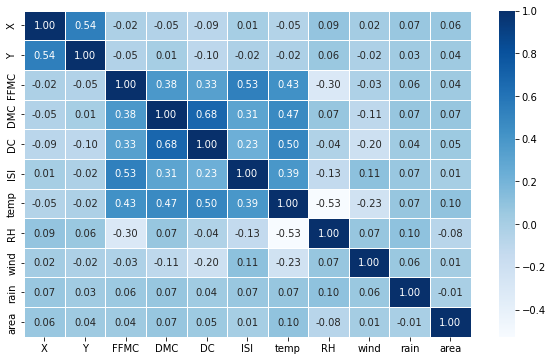

In [23]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True,linewidths = 0.5, fmt = ".2f", cmap='Blues');

## Target Feature is not correlated with any feature

# Lets Try some tree based models


In [24]:
%%time
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf.fit(X_train, y_train)
# checking the oob score
classifier_rf.oob_score_

CPU times: user 368 ms, sys: 57.4 ms, total: 426 ms
Wall time: 432 ms


0.5318559556786704

# Tuning for Random Forest using GridSearchCV and fit the data.

In [25]:
rf = RandomForestClassifier(random_state=7, n_jobs=-1)

In [26]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [29]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   44.6s


CPU times: user 3.53 s, sys: 157 ms, total: 3.69 s
Wall time: 1min 11s


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.2min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=7),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [30]:
grid_search.best_score_

0.5761294261294261

In [31]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=7)

In [32]:
classifier_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=10,n_jobs=-1, random_state=7)
classifier_rf.fit(X_train, y_train)
classifier_rf.score(X_test,y_test)

0.5705128205128205

# Now let’s perform RF for regression 

In [33]:
X_train , X_test , y_train, y_test = preprocess_input(df, task='regression')

In [34]:
%%time
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(X_train, y_train)  
regressor.score(X_test,y_test)

CPU times: user 356 ms, sys: 345 µs, total: 356 ms
Wall time: 356 ms


-1.060119248714316

## Each and every model failed... I think it's because this imbalanced dataset thats y

## In next note book I will try to improve my score using imbalance class